# Uncertainty: description vs. propagation

`Miguel Cerviño 27 Nov 2024`

References (ask me if you do not find any of them):
    <ul>
        <li><a href="https://www.iso.org/sites/JCGM/GUM-introduction.htm"><i>Guide to the expresion of uncertainty in measurements, GUM</i></a> (form the International Standarization Organization, ISO)<br>
            In particular <a href="https://www.iso.org/sites/JCGM/GUM/JCGM100/C045315e-html/C045315e.html?csnumber=50461">Sect 7: Reporting uncertainty</a></li>
        <li><i>Kendall's Advanced Theory of Statistics</i> (Vol 1 Cap.1,2,3)) It is in CAB library</li>
        <li>D'Agostini (2013) <i>Bayesian reasoning in data analisys . A critical introduction</i> World Scientific Publishing 2003 (<a href="https://www.roma1.infn.it/~dagos/WSPC/index.html">Table of contents</a>)</li>
        <li> <font color="green" >&#128073; </font> D'Agostini &amp; Raso (2000) <i>Uncertainties due to imperfect knowledge of systematic effects</i> (<a href="http://arxiv.org/abs/hep-ex/0002056v1">http://arxiv.org/abs/hep-ex/0002056v1</a>)</li>
        <li>Maíz-Apellániz &amp; Úbeda Ap.J. 2005, 629, 873, <a href="https://ui.adsabs.harvard.edu/abs/2005ApJ...629..873M/abstract"><i>Numerical Biases on Initial Mass Function Determinations Created by Binning</i></a></li>
    </ul>


## 0. Preliminaries: Some useful functions

### Import 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sys

from numpy import empty
from scipy.special import erfinv, erf
#from scipy.stats import triang
#Estos dos no se si se usan!!!
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import AutoMinorLocator

### Analisys functions

<ul>
    <li>Index function (<font color="#8888aa"><i>is_odd</i></font>)</li>
    <li>Plotting histogram functions (<font color="#8888aa"><i>plot_histloglin, plot_histloglog, plot_histlinlog</i></font>)</li>
    <li>&#128073;  Analisys functions: mean and sigma, median and quartil, mode and CL, and PDF plotting functions (<font color="#8888aa"><i>PlotPDF(x, Qmedian, Qcl)</i></font>)</li>
    <li> Definitions (<font color="#8888aa"><i>&lt;function&gt;FUN</i></font>), Montecarlo samplig (<font color="#8888aa"><i>&lt;function&gt;PDF</i></font>), Monments and Quantiles (<font color="#8888aa"><i>&lt;function&gt;MomentsAndQantiles</i></font>) and histogram and function ploting (<font color="#8888aa"><i>&lt;function&gt;PLOT</i></font>) of some asymmetric PDFs
        <ol>
        <li>PowerLaw PDF and analitical moments and quartiles (<font color="#8888aa"><i>powerlaw</i></font>)</li>
        <li>Triangular PDF and analitical moments and quartiles (<font color="#8888aa"><i>tirangular</i></font>)</li>
        <li>Splitnormal PDF and analitical moments and quartiles (<font color="#8888aa"><i>splitnormal</i></font>)</li>
        </ol>
    </li>
</ul>

#### Code with Functions

In [10]:
def is_odd(num):
    return num & 0x1

# Plot an histogram in log-linear, 
#taken from https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib/54529366#54529366
def plot_histloglin(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,density=True)
  plt.xscale('log')

# Plot an histogram in log-log, 
def plot_histloglog(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,density=True)
  plt.xscale('log')
  plt.yscale('log')

# Plot an histogram in log-log, 
def plot_histlinlog(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  plt.hist(x, bins=bins,density=True)
  plt.yscale('log')

# example plot_histloglin(np.random.rand(200), 10)

#Plot histogram, obtain, mean, varinace, median, 90%Q, mode, 90%CL
def plot_PDF(x, Qmedian, Qcl, Nbins = 20, xlog=False, ylog=False, title=' ',xsize=12,ysize=5):
    xdata = np.array(x)

    # mean, median, Qmedian
    # mean
    xmean = np.mean(xdata)
    xstd = np.std(xdata)

    # Median and Quatil
    nQlow = 0.5 - (Qmedian / 2)
    nQmedian = 0.5
    nQup = 0.5 + ( Qmedian / 2)
    
    xQlow = np.quantile(xdata, nQlow)
    xmedian = np.quantile(xdata, nQmedian)
    xQup = np.quantile(xdata, nQup)

    # Mode
    # 1) sort array
    Npt = int(len(xdata))
    xsorted = np.take_along_axis(xdata,np.argsort(xdata),axis=0)

    # Mode an Intervals (assuming 20 bins and Npt is multiple by 20)
    Npt_bin = int(Npt / Nbins)

    Histo_array = []
    bins = []
    bins.append(xsorted[0])
    irun = 0
#    group_max = xsorted[0]
    for i in range(0, Npt, Npt_bin):
        group = xsorted[i:i + Npt_bin] # Select a group with Npt_bin elements
#        group_min = group_max
#        group_max = np.max(group)
        group_min = group[0]
        if i+Npt_bin+1 < Npt -1 :
            group_max = xsorted[i+Npt_bin+1]
        else :
            group_max = xsorted[Npt -1]            
        bins.append(group_max)
        bin_width = group_max - group_min # bins [a,b] implies a <= x < b, except for last bin
        Histo_array.append([group_max, group_min, bin_width])
    Histo_array = np.array(Histo_array)
    Mode_array = Histo_array[Histo_array[:, 2].argsort()]  # bin_width has index 2

    # All bins have the same value of Npt_bin, hence points up to reach the desired probability
    total_prob = 0.
    nbins_i = 0
    for element in Mode_array:
        total_prob += Npt_bin
        nbins_i += 1
        if total_prob / Npt >= Qcl: 
            break

    x_top = np.max(Mode_array[:nbins_i,0])
    x_bottom = np.min(Mode_array[:nbins_i,1])
    x_mode = (Mode_array[0,0] + Mode_array[0,1])/2

    print(f"     SUMMARIES    ")
    print(f" 1) mean   = {xmean:.4f}, sigma     = {xstd:.4f}; (mean - sigma = {(xmean-xstd):.4f}; mean - sigma = {(xmean+xstd):.4f}; )")
    print(f" 2) median = {xmedian:.4f}, Q{(0.5 - (Qmedian/2.)):.2f}     = {xQlow:.4f}, Q{(0.5 + (Qmedian/2.)):.2f}     = {xQup:.4f}")
    print(f" 3) mode   = {x_mode:.4f}, LowCL{Qcl:.2f} = {x_bottom:.4f}, upCL{Qcl:.2f} = {x_top:.4f}")
    print(f"     Test:    ")
    print(f"mode-median-mean:  mode - median = {(x_mode - xmedian):.4f}   median - mean = {((xmedian-xmean)):.4f}")
    print(f"Dooson 1917:  mode - mean = {(x_mode - xmean):.4f}   3(median - mean) = {(3.*(xmedian-xmean)):.4f}")
    print(f"    ")

    # Plot
    # Data with equal bins
    # plt.hist(xsorted, bins = bins, edgecolor='black', alpha=0.7) 

    frec = []
    frec = Npt_bin/Histo_array[:,2]/Npt
    frec = np.array(frec)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(xsize, ysize))
    axes[0].hist(xdata, bins=Nbins, color='orange',alpha=0.4, edgecolor='black',density=True)
    axes[1].bar (Histo_array[:,0], frec, width=Histo_array[:,1]-Histo_array[:,0], align='edge', color='violet', edgecolor='black',alpha=0.4)

    
#    plt.bar(inf, frec, width=Histo_array[:,2], aling='edge', ec='white')
#    plt.xticks(np.concatenate((Histo_array[:,0], Histo_array[:,1])))
    # Mean
    axes[0].axvline(xmean, color='black', linestyle='--', linewidth=4, label="Mean")
    axes[1].axvline(xmean, color='black', linestyle='--', linewidth=4, label="Mean")
    # Median and Quatile
    xmin, xmax = xQlow, xQup
    axes[0].axvspan(xmin, xmax, color='red', alpha=0.1, label="Quartile area")
    axes[0].axvline(xmedian, color='red', linestyle='--', linewidth=2, label="Median")
    axes[1].axvline(xmedian, color='red', linestyle='--', linewidth=2, label="Median")
    axes[1].axvline(xmin, color='red', linestyle='--', alpha=0.3, label="Quartile area")
    axes[1].axvline(xmax, color='red', linestyle='--', alpha=0.3)

    # Mode and CL
    xmin, xmax = x_bottom, x_top
    axes[0].axvline(x_mode, color='blue', linestyle='--', linewidth=2, label="Mode")
    axes[0].axvline(xmin, color='blue', linestyle='--', alpha=0.3, label="CL area")
    axes[0].axvline(xmax, color='blue', linestyle='--', alpha=0.3)
    axes[1].axvline(x_mode, color='blue', linestyle='--', linewidth=2, label="Mode")
    axes[1].axvspan(xmin, xmax, color='blue', alpha=0.1, label="CL area")


    # Configurar los minor ticks en ambos ejes
    axes[0].xaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje x
    axes[0].yaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje y
    axes[1].xaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje x
    axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje y

    # Activar los minor ticks en los bordes superior y derecho
    axes[0].tick_params(which='both', direction='in', top=True, right=True)         # Activar ticks en top y right
    axes[0].tick_params(which='minor', length=4, color='gray')      # Configurar minor ticks
    axes[1].tick_params(which='both', direction='in', top=True, right=True)         # Activar ticks en top y right
    axes[1].tick_params(which='minor', length=4, color='gray')      # Configurar minor ticks

    
    axes[0].set_xlabel("X")
    axes[1].set_xlabel("X")
    axes[0].set_ylabel("frecuency")
    axes[1].set_ylabel("frecuency")
    
    if xlog : 
        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
    if ylog : 
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(title)
    axes[1].set_title(title)

    plt.tight_layout() 
    plt.show()

    return  xmean, xstd, xmedian, xQlow, xQup, x_mode, x_bottom, x_top

# Añadimos etiquetas y mostramos el gráfico
# plt.xlabel("Puntos")
# plt.ylabel("Frecuencia")
# plt.title("Histograma Personalizado")
# plt.show()

In [11]:
def powerlawFUN(x,LeftX,RightX,slope):
    if LeftX > RightX :
        print(f"Error: Lower Limit > Upper limit")
        #raise Exception('Error: Lower Limit > Upper limit')
        sys.exit()
    xlow = LeftX
    xup = RightX
    alpha = slope

    if(np.abs(alpha + 1.) > 1.e-7) :
        Anorm = (np.power(xup,alpha + 1.) - np.power(xlow,alpha + 1.))/(alpha + 1.)
        Anorm = 1. / Anorm
    else :
        Anorm = np.log(xup/xlow)
        Anorm = 1. / Anorm
    return Anorm * np.power(x,slope)


def powerlawPDF(LeftX,RightX,slope,nMon = 100000):
    z = np.random.uniform(0.0, 1.0, nMon)
    xlow = LeftX
    xup = RightX
    alpha = slope
    if LeftX > RightX :
        print(f"Error: Lower Limit > Upper limit")
        #raise Exception('Error: Lower Limit > Upper limit')
        sys.exit()
    if(np.abs(alpha + 1.) > 1.e-7) :
        Anorm = (np.power(xup,alpha + 1.) - np.power(xlow,alpha + 1.))/(alpha + 1.)
        Anorm = 1. / Anorm
        x = np.power( (z * (alpha+1.) / Anorm) + np.power(xlow, alpha +1.), 1./(alpha + 1.))
    else :
        Anorm = np.log(xup/xlow)
        Anorm = 1. / Anorm
        x = xlow * np.exp(z / Anorm)
    return x

def powerlawMomentsAndQantiles(LeftX,RightX,slope,Qmedian): 
    xlow = LeftX
    xup = RightX
    alpha = slope
    if LeftX > RightX :
        print(f"Error: Lower Limit > Upper limit")
        #raise Exception('Error: Lower Limit > Upper limit')
        sys.exit()

    if(np.abs(alpha + 1.) > 1.e-7) :
        Anorm = (np.power(xup,alpha + 1.) - np.power(xlow,alpha + 1.))/(alpha + 1.)
        Anorm = 1. / Anorm
    else :
        Anorm = np.log(xup/xlow)
        Anorm = 1. / Anorm

    if(np.abs(alpha + 2.) > 1.e-7) :    
        xmean = Anorm * (np.power(xup,alpha + 2.) - np.power(xlow,alpha + 2.))/(alpha + 2.)
    else:
        xmean = Anorm * np.log(xup/xlow)

    if(np.abs(alpha + 3.) > 1.e-7) :    
        xstd = Anorm * (np.power(xup,alpha + 3.) - np.power(xlow,alpha + 3.))/(alpha + 3.)
    else:
        xstd = Anorm * np.log(xup/xlow)
    
    xstd = np.sqrt(xstd - (xmean*xmean))
    print(f" Analitical values: mean   = {xmean:.4f},   sigma = {xstd:.4f};")
    
    #Quantiles
    xQ = empty(3)
    xQ[0] = 0.5 - (Qmedian / 2.)
    xQ[1] = 0.5 
    xQ[2] = 0.5 + ( Qmedian / 2.)

    xOUT = empty(3)
    for i in range(0,3):
        if(np.abs(alpha + 1.) > 1.e-7) :
            xOUT[i] = np.power( (xQ[i] * (alpha+1.) / Anorm) + np.power(xlow, alpha +1.), 1./(alpha + 1.))
        else :
            xOUT[i] = xlow * np.exp(xQ[i]/ Anorm)

    print(f"                    median = {xOUT[1]:.4f}, Q{(0.5 - (Qmedian/2.)):.2f}   = {xOUT[0]:.4f}, Q{(0.5 + (Qmedian/2.)):.2f} = {xOUT[2]:.4f}")
    return xmean, xstd, xOUT[1],xOUT[0],xOUT[2]


def powerlawPLOT(LeftX,RightX,slope, nMon = 100000, Nbins = 20, xlog=False, ylog=False, title=' ',xsize=12,ysize=5):
    xdata = powerlawPDF(LeftX,RightX,slope, nMon = nMon)
    xmin_plot = np.min(xdata)
    xmax_plot = np.max(xdata)

    # 1) sort array
    Npt = int(len(xdata))
    xsorted = np.take_along_axis(xdata,np.argsort(xdata),axis=0)

    # Mode an Intervals (assuming Nbins bins (20 by default)  and Npt is multiple of Nbins)
    Npt_bin = int(Npt / Nbins)

    Histo_array = []
    bins = []
    bins.append(xsorted[0])
    group_max =xsorted[0]
    for i in range(0, Npt, Npt_bin):
        group = xsorted[i:i + Npt_bin] # Select a group with Npt_bin elements
        group_min = group_max
        group_max = np.max(group)
        bins.append(group_max)
        bin_width = group_max - group_min # bins [a,b] implies a <= x < b, except for last bin
        Histo_array.append([group_max, group_min, bin_width])
    Histo_array = np.array(Histo_array)
    Mode_array = Histo_array[Histo_array[:, 2].argsort()]  # bin_width has index 2

    # Plot
    # Data with equal bins
    # plt.hist(xsorted, bins = bins, edgecolor='black', alpha=0.7) 

    frec = []
    frec = Npt_bin/Histo_array[:,2]/Npt
    frec = np.array(frec)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(xsize, ysize))
    axes[0].hist(xdata, bins=Nbins, color='orange',alpha=0.4, edgecolor='black',density=True)
    axes[1].bar (Histo_array[:,0], frec, width=Histo_array[:,1]-Histo_array[:,0], align='edge', color='violet', edgecolor='black',alpha=0.4)

    x = np.linspace(xmin_plot,xmax_plot,100)
    axes[0].plot(x,powerlawFUN(x,LeftX,RightX,slope),'r',alpha=0.6)
    axes[1].plot(x,powerlawFUN(x,LeftX,RightX,slope),'r',alpha=0.6)

    
    # Configurar los minor ticks en ambos ejes
    axes[0].xaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje x
    axes[0].yaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje y
    axes[1].xaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje x
    axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje y

    # Activar los minor ticks en los bordes superior y derecho
    axes[0].tick_params(which='both', direction='in', top=True, right=True)         # Activar ticks en top y right
    axes[0].tick_params(which='minor', length=4, color='gray')      # Configurar minor ticks
    axes[1].tick_params(which='both', direction='in', top=True, right=True)         # Activar ticks en top y right
    axes[1].tick_params(which='minor', length=4, color='gray')      # Configurar minor ticks

    axes[0].set_xlabel("X")
    axes[1].set_xlabel("X")
    axes[0].set_ylabel("frecuency")
    axes[1].set_ylabel("frecuency")
    
    if xlog : 
        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
    if ylog : 
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')

    axes[0].set_title(title)
    axes[1].set_title(title)

    plt.tight_layout() 
    plt.show()

    return  

In [12]:
def triangularFUN(x,LeftX,MaxX,RightX):
    x0 = MaxX
    a = LeftX
    b = RightX
    if LeftX > RightX :
        print(f"Error: Lower Limit > Upper limit")
        #raise Exception('Error: Lower Limit > Upper limit')
        sys.exit()
    if x0 > RightX :
        print(f"Error: Triangle Vertice > Upper limit")
        sys.exit()
    if x0 < LeftX :
        print(f"Error: Triangle Vertice < Lower limit")
        sys.exit()

    # Opcion  1 use scipy.stats
    # Convertir a la escala de scipy (c es la ubicación del modo en el intervalo [0, 1])
    # c = (x0 - a) / (b - a)
    # return triang.pdf(x, c, loc= a, scale = b - a)
    
    conditions = [
        x < LeftX ,
        (x >= LeftX) & (x < MaxX), 
        (x >= MaxX) & (x <= RightX),
        x > RightX
    ]
        
    h = 2./(b-a)
    functions = [
        lambda x: 0.,
        lambda x: h * ( x - a) / (MaxX -a),
        lambda x: h * ( b - x ) / (b - MaxX),
        lambda x: 0.
    ]
        
    return np.piecewise(x, conditions, functions)
        

def triangularPDF(LeftX,MaxX,RightX,nMon = 100000):
    z = np.random.uniform(0.0, 1.0, nMon)
    x = empty(nMon)
    x0 = MaxX
    a = LeftX
    b = RightX
    if LeftX > RightX :
        print(f"Error: Lower Limit > Upper limit")
        #raise Exception('Error: Lower Limit > Upper limit')
        sys.exit()
    if x0 > RightX :
        print(f"Error: Triangle Vertice > Upper limit")
        sys.exit()
    if x0 < LeftX :
        print(f"Error: Triangle Vertice < Lower limit")
        sys.exit()
    h = 2./(b-a)
    for i in range(nMon):
        if (h*(x0-a)/2.)  >= z[i]:
            x[i] = a + np.sqrt(((2.*(x0-a)*z[i])/h))
        else:
            x[i] = b - np.sqrt( (b-x0)*(b-x0) - ((2.*(b-x0)*(z[i]-((h*(x0-a))/2.)))/h))
        if( x[i] <= a ):
            print("Error!! Thisn never must happen!!")
            sys.exit()
    return x

def triangularMomentsAndQantiles(LeftX,MaxX,RightX,Qmedian): 
    if LeftX > RightX :
        print(f"Error: Lower Limit > Upper limit")
        #raise Exception('Error: Lower Limit > Upper limit')
        sys.exit()
    if MaxX > RightX :
        print(f"Error: Triangle Vertice > Upper limit")
        sys.exit()
    if MaxX < LeftX :
        print(f"Error: Triangle Vertice < Lower limit")
        sys.exit()
    
    #Moments: D'Agostini & Raso 2000 https://arxiv.org/pdf/hep-ex/0002056v1
    DeltaXminus = MaxX -  LeftX
    DeltaXplus = RightX - MaxX 
    xmean = MaxX + (DeltaXplus - DeltaXminus) / 3.
    xstd = ((DeltaXplus * DeltaXplus) + (DeltaXminus*DeltaXminus) + DeltaXplus*DeltaXminus) / 18.
    xstd = np.sqrt(xstd)
    print(f" Analitical values: mean   = {xmean:.4f},   sigma = {xstd:.4f};")

    #Quantiles
    xQ = empty(3)
    xQ[0] = 0.5 - (Qmedian / 2.)
    xQ[1] = 0.5 
    xQ[2] = 0.5 + ( Qmedian / 2.)

    x0 = MaxX
    a = LeftX
    b = RightX
    h = 2./(b-a)

    xOUT = empty(3)
    for i in range(0,3):
        if (h*(x0-a)/2.)  >= xQ[i]:
            xOUT[i] = a + np.sqrt(((2.*(x0-a)*xQ[i])/h))
        else:
            xOUT[i] = b - np.sqrt( (b-x0)*(b-x0) - ((2.*(b-x0)*(xQ[i]-((h*(x0-a))/2.)))/h))
    print(f"                    median = {xOUT[1]:.4f}, Q{(0.5 - (Qmedian/2.)):.2f}   = {xOUT[0]:.4f}, Q{(0.5 + (Qmedian/2.)):.2f} = {xOUT[2]:.4f}")
    return xmean, xstd, xOUT[1],xOUT[0],xOUT[2]



#Plot histogram, obtain, mean, varinace, median, 90%Q, mode, 90%CL
def triangularPLOT(LeftX,MaxX,RightX, nMon = 100000, Nbins = 20, xlog=False, ylog=False, title=' ',xsize=12,ysize=5):
    xdata = triangularPDF(LeftX,MaxX,RightX, nMon)
    xmin_plot = np.min(xdata)
    xmax_plot = np.max(xdata)

    # 1) sort array
    Npt = int(len(xdata))
    xsorted = np.take_along_axis(xdata,np.argsort(xdata),axis=0)

    # Mode an Intervals (assuming 20 bins and Npt is multiple by 20)
    #    Nbins = 20
    Npt_bin = int(Npt / Nbins)

    Histo_array = []
    bins = []
    bins.append(xsorted[0])
    group_max =xsorted[0]
    for i in range(0, Npt, Npt_bin):
        group = xsorted[i:i + Npt_bin] # Select a group with Npt_bin elements
        group_min = group_max
        group_max = np.max(group)
        bins.append(group_max)
        bin_width = group_max - group_min # bins [a,b] implies a <= x < b, except for last bin
        Histo_array.append([group_max, group_min, bin_width])
    Histo_array = np.array(Histo_array)
    Mode_array = Histo_array[Histo_array[:, 2].argsort()]  # bin_width has index 2

    # Plot
    # Data with equal bins
    # plt.hist(xsorted, bins = bins, edgecolor='black', alpha=0.7) 

    frec = []
    frec = Npt_bin/Histo_array[:,2]/Npt
    frec = np.array(frec)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(xsize, ysize))
    axes[0].hist(xdata, bins=Nbins, color='orange',alpha=0.4, edgecolor='black',density=True)
    axes[1].bar (Histo_array[:,0], frec, width=Histo_array[:,1]-Histo_array[:,0], align='edge', color='violet', edgecolor='black',alpha=0.4)

    x = np.linspace(xmin_plot,xmax_plot,100)
    axes[0].plot(x,triangularFUN(x,LeftX,MaxX,RightX),'r',alpha=0.6)
    axes[1].plot(x,triangularFUN(x,LeftX,MaxX,RightX),'r',alpha=0.6)
    
    # Configurar los minor ticks en ambos ejes
    axes[0].xaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje x
    axes[0].yaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje y
    axes[1].xaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje x
    axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje y

    # Activar los minor ticks en los bordes superior y derecho
    axes[0].tick_params(which='both', direction='in', top=True, right=True)         # Activar ticks en top y right
    axes[0].tick_params(which='minor', length=4, color='gray')      # Configurar minor ticks
    axes[1].tick_params(which='both', direction='in', top=True, right=True)         # Activar ticks en top y right
    axes[1].tick_params(which='minor', length=4, color='gray')      # Configurar minor ticks

    axes[0].set_xlabel("X")
    axes[1].set_xlabel("X")
    axes[0].set_ylabel("frecuency")
    axes[1].set_ylabel("frecuency")
    
    if xlog : 
        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
    if ylog : 
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')

    axes[0].set_title(title)
    axes[1].set_title(title)

    plt.tight_layout() 
    plt.show()

    return  

In [13]:
def splitnormalFUN(x,moda,sigma_left,sigma_right):
    mode = moda
    s_l = sigma_left
    s_r = sigma_right

    conditions = [
        x < moda ,
        x >= moda
    ]

    Anorm = np.sqrt(2./math.pi)*(1./(s_l+s_r))
    functions = [
        lambda x: Anorm * np.exp(-(x - moda)*(x - moda)/(2.*s_l*s_l)),
        lambda x: Anorm * np.exp(-(x - moda)*(x - moda)/(2.*s_r*s_r))
    ]
        
    return np.piecewise(x, conditions, functions)
        

def splitnormalPDF(moda,sigma_left,sigma_right,nMon = 100000):
    # Slipt normal definition: (sqrt(2/pi))*(1/(sig1+sig2) * exp (x-mode(/2sigma_i^2) where sigma_i varies if it is right or left the mode
    # Integral -inf up to x left mode: sig1*(1+Erf[(x-mu)/(sig1*sqrt2)]) /  (sig1+sig2)
    # Integral up to mu: sig1/(sig1+sig2) It is de ficudal CDF value
    # Integral up tu x right mode: (sig1/(sig1+sig2)) + sig2*Erf[(x-mu)/(sig1*sqrt2)] / (sig1+sig2) =
    #                              (sig1+sig2*Erf[(x-mu)/(sig1*sqrt2)]) /  (sig1+sig2)

    z = np.random.uniform(0.0, 1.0, nMon)
    x = empty(nMon)

    for i in range(nMon):
        if (sigma_left/(sigma_left+sigma_right))  >= z[i]:
            x[i] = (z[i]*(sigma_left+sigma_right)/sigma_left) - 1.
            x[i] = moda + (np.sqrt(2.)*sigma_left)*erfinv(x[i])
        else:
            x[i] = (z[i]*(sigma_left+sigma_right) - sigma_left)/sigma_right
            x[i] = moda + (np.sqrt(2.)*sigma_right)*erfinv(x[i])

    return x
    
def splitnormalMomentsAndQantiles(moda,sigma_left,sigma_right,Qmedian):
    xmean = moda + (np.sqrt(2./math.pi) * (sigma_right - sigma_left))
    variance = (1. - (2./math.pi))*(sigma_right - sigma_left)*(sigma_right - sigma_left) + (sigma_right * sigma_left)
    xstd = np.sqrt(variance)
    
    print(f" Analitical values: mean   = {xmean:.4f},   sigma = {xstd:.4f};")

    #Quantiles
    xQ = empty(3)
    xQ[0] = 0.5 - (Qmedian / 2.)
    xQ[1] = 0.5 
    xQ[2] = 0.5 + ( Qmedian / 2.)

    xOUT = empty(3)
    for i in range(0,3):
        if (sigma_left/(sigma_left+sigma_right))  >= xQ[i]:
            xOUT[i] = (xQ[i]*(sigma_left+sigma_right)/sigma_left) - 1.
            xOUT[i] = moda + (np.sqrt(2.)*sigma_left)*erfinv(xOUT[i])
        else:
            xOUT[i] = (xQ[i]*(sigma_left+sigma_right) - sigma_left)/sigma_right
            xOUT[i] = moda + (np.sqrt(2.)*sigma_right)*erfinv(xOUT[i])

    
    print(f"                    median = {xOUT[1]:.4f}, Q{(0.5 - (Qmedian/2.)):.2f}   = {xOUT[0]:.4f}, Q{(0.5 + (Qmedian/2.)):.2f} = {xOUT[2]:.4f}")
    return xmean, xstd, xOUT[1],xOUT[0],xOUT[2]

#Plot histogram, obtain, mean, varinace, median, 90%Q, mode, 90%CL
def splitnormalPLOT(moda,sigma_left,sigma_right, nMon = 100000, Nbins = 20, xlog=False, ylog=False, title=' ',xsize=12,ysize=5):
    xdata = splitnormalPDF(moda,sigma_left,sigma_right,nMon)
    xmin_plot = np.min(xdata)
    xmax_plot = np.max(xdata)
    
    # 1) sort array
    Npt = int(len(xdata))
    xsorted = np.take_along_axis(xdata,np.argsort(xdata),axis=0)

    # Mode an Intervals (assuming 20 bins and Npt is multiple by 20)
    #    Nbins = 20
    Npt_bin = int(Npt / Nbins)

    Histo_array = []
    bins = []
    bins.append(xsorted[0])
    group_max =xsorted[0]
    for i in range(0, Npt, Npt_bin):
        group = xsorted[i:i + Npt_bin] # Select a group with Npt_bin elements
        group_min = group_max
        group_max = np.max(group)
        bins.append(group_max)
        bin_width = group_max - group_min # bins [a,b] implies a <= x < b, except for last bin
        Histo_array.append([group_max, group_min, bin_width])
    Histo_array = np.array(Histo_array)
    Mode_array = Histo_array[Histo_array[:, 2].argsort()]  # bin_width has index 2

    # Plot
    # Data with equal bins
    # plt.hist(xsorted, bins = bins, edgecolor='black', alpha=0.7) 

    frec = []
    frec = Npt_bin/Histo_array[:,2]/Npt
    frec = np.array(frec)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(xsize, ysize))
    axes[0].hist(xdata, bins=Nbins, color='orange',alpha=0.4, edgecolor='black',density=True)
    axes[1].bar (Histo_array[:,0], frec, width=Histo_array[:,1]-Histo_array[:,0], align='edge', color='violet', edgecolor='black',alpha=0.4)

    
    x = np.linspace(xmin_plot,xmax_plot,100)
    axes[0].plot(x,splitnormalFUN(x,moda,sigma_left,sigma_right),'r',alpha=0.6)
    axes[1].plot(x,splitnormalFUN(x,moda,sigma_left,sigma_right),'r',alpha=0.6)

    
    # Configurar los minor ticks en ambos ejes
    axes[0].xaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje x
    axes[0].yaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje y
    axes[1].xaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje x
    axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))  # Minor ticks en el eje y

    # Activar los minor ticks en los bordes superior y derecho
    axes[0].tick_params(which='both', direction='in', top=True, right=True)         # Activar ticks en top y right
    axes[0].tick_params(which='minor', length=4, color='gray')      # Configurar minor ticks
    axes[1].tick_params(which='both', direction='in', top=True, right=True)         # Activar ticks en top y right
    axes[1].tick_params(which='minor', length=4, color='gray')      # Configurar minor ticks

    axes[0].set_xlabel("X")
    axes[1].set_xlabel("X")
    axes[0].set_ylabel("frecuency")
    axes[1].set_ylabel("frecuency")
    
    if xlog : 
        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
    if ylog : 
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')

    axes[0].set_title(title)
    axes[1].set_title(title)

    plt.tight_layout() 
    plt.show()

    return  

## 1. Representations of Uncertainty (PDFs)

There are lots of probability distributions, they aims to describe the _possible_ otucomes of a process and are called Prbability Density Distributions, PDFs. Examples are the Mawell-Boltzmann distribution, the Initial Mass Function, Gaussian distributions, Poison distributions and so on.

The idea is describe the probability that a event (or a parameter or whatever you want) is enclosed in a given range. In general each PDF is linked with the particular process they describe: Poison work for photon counting, Gaussian for realeated independent measurements, Mawell-Boltzmann for free electorns, IMF for stellar masses and so on.

Let us assume a few cases cases of asimetric distributions:

- a PowerLaw PDF (as the IMF) with limits $x_\mathrm{min}$, $x_\mathrm{max}$, and exponet $\alpha$ (with $\alpha \neq -1$)

\begin{eqnarray}
\varphi_1(x) &=& \frac{\alpha -1}{x_\mathrm{max}^{\alpha +1} - x_\mathrm{min}^{\alpha +1}} \, \,  x^\alpha \\
\mathrm{CDF}[\varphi_1(x)] = z = \int_{-\infty}^x \varphi_1(x) \, \mathrm{d}x &=& \frac{\alpha -1}{x_\mathrm{max}^{\alpha +1} - x_\mathrm{min}^{\alpha +1}} \frac{x^{\alpha+1} - x_\mathrm{min}^{\alpha+1}}{\alpha+1} = \frac{x^{\alpha+1} - x_\mathrm{min}^{\alpha+1}}{x_\mathrm{max}^{\alpha +1} - x_\mathrm{min}^{\alpha +1}}\\
x &=& (z \times (x_\mathrm{max}^{\alpha +1} - x_\mathrm{min}^{\alpha +1}) + x_\mathrm{min}^{\alpha+1} )^\frac{1}{\alpha + 1}
\end{eqnarray}

- a <a href="https://en.wikipedia.org/wiki/Triangular_distribution">Triangular PDF</a> which begins at point $(a,0)$, has a maximun at $(\hat{x},h)$ and ends at point $(b,0)$, so $h = 2/(b-a)$ to keep the total area equal to 1.

\begin{eqnarray}
\varphi_2(x) &=&
    \begin{cases}
        \frac{h}{\hat{x}-a} \, (x- a) & \text{if } x < \hat{x}\\
        \frac{h}{b-\hat{x}} \, (b - x) & \text{if } x \geq \hat{x}
    \end{cases} \\
\mathrm{CDF}[\varphi_2(x)] = z = \int_{-\infty}^x \varphi_2(x) \, \mathrm{d}x &=&
    \begin{cases}
        \frac{h}{2\, (\hat{x}-a)} \, (x-a)^2  & \text{if } x < \hat{x}\\
        \frac{h\, (\hat{x}-a)}{2} - \frac{h}{2\,(b-\hat{x})} ((b-\hat{x})^2 - (b-x)^2) & \text{if } x \geq \hat{x}
    \end{cases} \\
x &=&
    \begin{cases}
        a + \sqrt{\frac{2\, (\hat{x}-a)\, z}{h}}  & \text{if } z <  \frac{h\, (\hat{x}-a)}{2}\\
        b - \sqrt{(b-\hat{x})^2 - \frac{2\, (b-\hat{x})\, \left(z - \frac{h\, (\hat{x}-a)}{2}\right)}{h}} & \text{if } z \geq \frac{h\, (\hat{x}-a)}{2}
    \end{cases} \\
\end{eqnarray}

- a <a href="https://en.wikipedia.org/wiki/Split_normal_distribution">Slipt-normal PDF</a> which is a two normal distributions with diferent dispersion at the left ($\sigma_\mathrm{l}$) and right ($\sigma_\mathrm{r}$) of a given value $\hat{m}$.


\begin{eqnarray}
\varphi_3(x) &=&
    \begin{cases}
        \sqrt{\frac{2}{\pi}}\,\frac{1}{\sigma_\mathrm{l}+\sigma_\mathrm{r}} \,\, \exp \left( - \frac{(x-\hat{m})^2}{2\,\sigma_\mathrm{l}^2} \right) & \text{if } x < \hat{m}\\
        \sqrt{\frac{2}{\pi}}\,\frac{1}{\sigma_\mathrm{l}+\sigma_\mathrm{r}} \,\, \exp \left( - \frac{(x-\hat{m})^2}{2\,\sigma_\mathrm{r}^2} \right)  & \text{if } x \geq \hat{m}
    \end{cases} \\
\mathrm{CDF}[\varphi_3(x)] = z = \int_{-\infty}^x \varphi_1(x) \, \mathrm{d}x = &=&
    \begin{cases}
        \frac{\sigma_\mathrm{l}}{\sigma_\mathrm{l} + \sigma_\mathrm{r}} ( 1 + \mathrm{Erf}\left[\frac{x-\hat{m}}{\sqrt{2} \sigma_\mathrm{l}}\right] ) & \text{if } x < \hat{m}\\
        \frac{1}{\sigma_\mathrm{l} + \sigma_\mathrm{r}} ( \sigma_\mathrm{l} + \sigma_\mathrm{r} \,\mathrm{Erf}\left[\frac{x-\hat{m}}{\sqrt{2} \sigma_\mathrm{r} }\right] ) & \text{if } x \geq \hat{m}
    \end{cases} \\
x &=&
    \begin{cases}
        \hat{m} + \sqrt{2}\,\sigma_\mathrm{l}\, \mathrm{Erf}\left[\frac{z  (\sigma_\mathrm{l} + \sigma_\mathrm{r})}{\sigma_\mathrm{l}} - 1\right] & \text{if } z < \frac{\sigma_1}{\sigma_1 + \sigma_2}  \\
                \hat{m} + \sqrt{2}\,\sigma_\mathrm{r}\, \mathrm{Erf}\left[\frac{z  (\sigma_\mathrm{l} + \sigma_\mathrm{r}) - \sigma_\mathrm{l}}{\sigma_\mathrm{r}}\right] & \text{if } z \geq \frac{\sigma_1}{\sigma_1 + \sigma_2}
    \end{cases} \\
\end{eqnarray}

#### How to make the representatión?

<ol>
    <li>Plot the PDF ussing the functional form</li>
    <li>Make a simulation and plot the resulta in an Histogram with
        <ol>
            <li> <i>Regular bin size</i>  (but they may product empty bins &#129300;)</li>
            <li> &#128073;  Bins wiht equal area (i.e. equal probability), which asure a continous description of the PDF and, hence, a better fit if requiered &#128571;</li>
        </ol>
    </li>
</ol>

<b>IMPORTANT</b>
In histograms you must define clearly the meaning of the intervals!! (it is, the meaning of the integral limits for a continous PDFs)<br>

<center>
    They must be <font color="green">$a \le x \lt b$</font> or <font color="green">$a \lt x \le b$</font> but not <font color="red">$a \le x \le b$</font>
</center>

<br>
Example IGIMF theory by Kroupa et al. (<a href="https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..187W/abstract">Weidner &amp: Kroupa 2004, MNRAS 348, 187</a> and posterior works) make the incorrect use of it and assume $a \le x \le b$ in the integral limits, so the whole theory is mathematically incorrect <font color="green" >&#129318;&#127997; </font>!!
(see <a href="https://ui.adsabs.harvard.edu/abs/2013A%26A...553A..31C/abstract">Cerviño et al. 2013, A&amp;A 553, A31</a> for details)

#### Examples

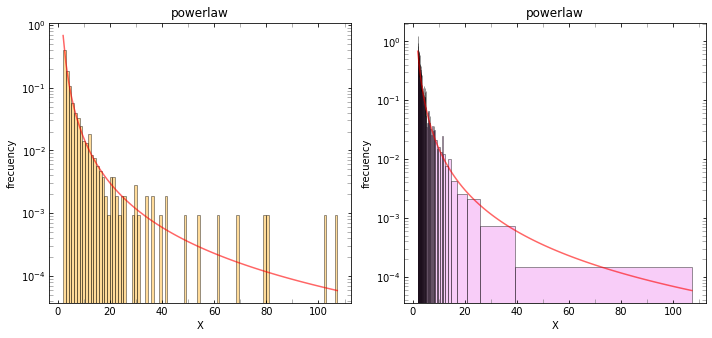

In [14]:
# See more example of fitting the IMF in Maíz-Apellániz & Úbeda Ap.J. 2005, 629, 873
powerlawPLOT(2.,120.,-2.35, Nbins=100, nMon=1000,  ylog=True, xsize=10,ysize= 4.8, title="powerlaw")

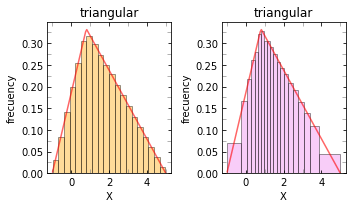

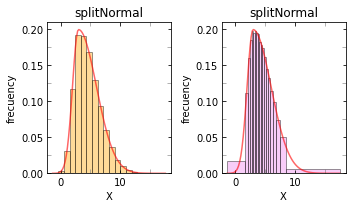

In [15]:
#OTHER EXAMPLES:
triangularPLOT(-1.,0.80,5.,xsize=5,ysize= 3, title="triangular")

splitnormalPLOT(3.,1.,3.,Nbins=20, nMon=100000, xsize=5,ysize= 3, title="splitNormal")

## 2. Measurement of location and dispersion

### Definitions

Work directlly with PDFs would be cumbersome, and some times we only want to have some <i>summaries</i> of the PDF $\varphi(x)$. It is, a few <i>numbers</i> which give an idea about the distribution, and which we can use for work in further analisys. They can be called generiacally <i>central values</i> and <i>uncertainties</i>, althought there can be defined in several ways. Some of them are:

<ol>
    <li>Mean, $\mu$, and variance, $\sigma^2$, or standard devaition, $\sigma$ (and skwness, kurtosis and high-order raw and central moments, $\mu'_n$ and $\mu_n$):
      \begin{eqnarray}
        \mu'_1 = \mu' = \mu &=& \int \, x\, \varphi(x) \mathrm{d}x \\
        \sigma^2 = \mu_2 &=& \int \,(x-\mu')^2 \,\varphi(x)\,\mathrm{d}x = \left(\int\, x^2\,\varphi(x)\,\mathrm{d}x \right) - {\mu'}^2\\
        \mu'_n = \int \, x^n \, \varphi(x) \mathrm{d}x \,\,\,\,\,& & \,\,\,\,\,\mu_n = \int \, (x - \mu' )^n \, \varphi(x) \mathrm{d}x
      \end{eqnarray}
    </li>
    <li>Median, $\bar{x}$ (non standard notation), and percentils Qx.x (the median is the 50% percentil, $\bar{x} = \mathrm{Q}0.5$). 
        It can be directlly obtained from the inversion of $\mathrm{CDF}[\varphi_3(x)]$
        \begin{eqnarray}
          0.5 &=& \int_{-\infty}^{\mathrm{\bar{x}}} \, \varphi(x) \mathrm{d}x \\
          0.1 &=& \int_{-\infty}^{\mathrm{Q0.1}} \, \varphi(x) \mathrm{d}x \\
          0.9 &=& \int_{-\infty}^{\mathrm{Q0.9}} \, \varphi(x) \mathrm{d}x 
        \end{eqnarray}
    </li>
    <li>Mode, $\hat{x}$ (non standard notation), and the minimun $\Delta x$  which covers a given probability value 
        hence probailities arond the mode (here CL interval, but non standard name); ussing a probablity of 68\% as example) 
        \begin{eqnarray}
          \hat{x} & = & \mathrm{MAX}[\varphi(x)] \\
          \mathrm{MIN[\Delta x (= upCL-lowCL)]} & : & 0.68  = \int_\mathrm{lowCL}^\mathrm{upCL} \, \varphi(x) \mathrm{d}x 
        \end{eqnarray}
    </li>
</ol>

#### Outline for dispersion around the mode

<ol>
<li>Step 1: <i>histograms whith similar area</i>
    <ol>
        <li>Sort the data (similar to requerimetns to make de median)</li>
        <li>Make $N_\mathrm{bins}$ with $N_\mathrm{data}/N_\mathrm{bins}$ elements each (<i>all groups with the same number of data items, hence equal probability</i> $1/N_\mathrm{bins}$)</li>
        <li>Obtain the $x_{\mathrm{min},i}$ and $x_{\mathrm{max},i}$ of each group and the size of the bin $\Delta x_i = x_{\mathrm{min},i+1} - x_{\mathrm{min},i}$, and make an array  $[x_{\mathrm{min},i}, \Delta x_i, x_{\mathrm{max},i}]$. IMPORTANT: Note, that actually you must use $x_{\mathrm{min},i+1}$ instead the nominal $x_{\mathrm{max},i}$ value to define teh size of the bin, since bins must be defined as $x_{\mathrm{min},i} \le x \lt x_{\mathrm{min},i+1}$ and not as $x_{\mathrm{min},i} \le x \le x_{\mathrm{max},i}$; formally, $x_{\mathrm{max},i}$ is only i¡used for the last bin. It assure continuity.</li>
    </ol>
<br><br>
</li>
<li>Step 2: <i>Probability computations</i>
    <ol>
        <li>Sort the array with $\Delta x_i$ from lower to max</li>
        <li>The first element of the sorted array contains the mode: each group have an equal probability (i.e. area), lower $\Delta x_i$ implies larger probability of the bin</li>
        <li>Add elements of the sorted array up to the desired probability value, keeping the $\mathrm{min}[x_{min,i}]$ and $\mathrm{max}[x_{max,i}]$ values to define the $\mathrm{lowCL}$ and $\mathrm{upCL}$ values (or intervals) </li>
    </ol>
</li>
</ol>

 Analitical values: mean   = 7.3333,   sigma = 0.8498;
                    median = 7.4495, Q0.16   = 6.3856, Q0.84 = 8.2000
     SUMMARIES    
 1) mean   = 7.3342, sigma     = 0.8475; (mean - sigma = 6.4867; mean - sigma = 8.1816; )
 2) median = 7.4475, Q0.16     = 6.3943, Q0.84     = 8.1961
 3) mode   = 7.9463, LowCL0.68 = 6.5550, upCL0.68 = 8.3682
     Test:    
mode-median-mean:  mode - median = 0.4988   median - mean = 0.1133
Dooson 1917:  mode - mean = 0.6122   3(median - mean) = 0.3400
    


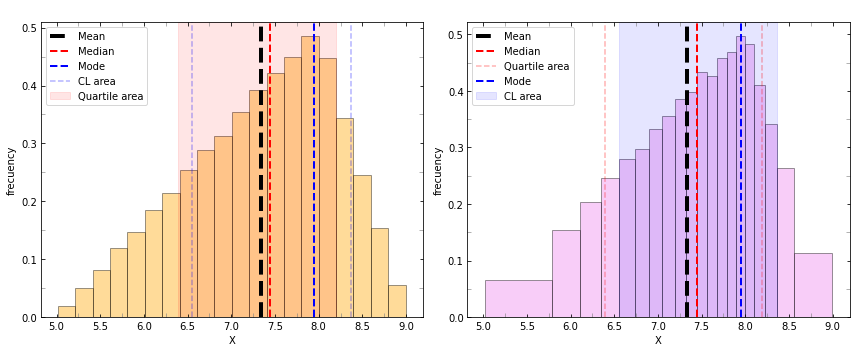

In [27]:
# xdata = powerlawPDF(1,15,-1.5)
xdata = triangularPDF(5.,8.,9.)
# xdata = splitnormalPDF(2.,0.5,9.)

# powerlawMomentsAndQantiles(1,15,-1.5,0.68)
triangularMomentsAndQantiles(5.,8.,9.,0.68)
# splitnormalMomentsAndQantiles(2.,0.5,9.,0.68)

# plot_PDF provides an array with mean, std, median, Qlow, Qup, mode, CLlow, CLup
a = []
a = plot_PDF(xdata,0.68,0.68)

### Tricks

Some tricks for unimodal PDFs Kendall's Cap. 2, 2.9:
<ul>
<li> with <b>very moderate</b> asymmetry Doodson 1917 (<a href="https://www.jstor.org/stable/pdf/2331833">https://www.jstor.org/stable/pdf/2331833</a>)

\begin{equation}
{\color{green}  \mathrm{mode} - \mu = 3 (\mathrm{median} - \mu)}
\end{equation}

Interstingly, the modal filter used by IRAF asume this relation ( <a href="https://iraf.readthedocs.io/en/latest/tasks/images/imfilter/rmode.html">https://iraf.readthedocs.io/en/latest/tasks/images/imfilter/rmode.html</a> )
</li>

<li>As empirical mnemonic rule, in general <b>Mean, median and mode occur in the same order (or reverse order) as in the dictionary</b>, and the median is close to de mean than to the mode (as in the dictionary).</li>

</ul>

 Analitical values: mean   = 10.0000,   sigma = 5.4006;
                    median = 9.1886, Q0.16   = 4.4721, Q0.84 = 16.0557
     SUMMARIES    
 1) mean   = 10.0046, sigma     = 5.3987; (mean - sigma = 4.6059; mean - sigma = 15.4033; )
 2) median = 9.2015, Q0.16     = 4.4770, Q0.84     = 16.0544
 3) mode   = 5.3224, LowCL0.68 = 2.5053, upCL0.68 = 13.8147
     Test:    
mode-median-mean:  mode - median = -3.8791   median - mean = -0.8031
Dooson 1917:  mode - mean = -4.6822   3(median - mean) = -2.4093
    


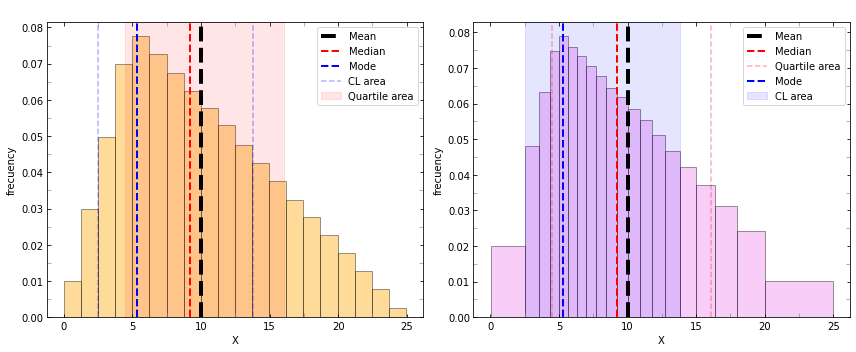

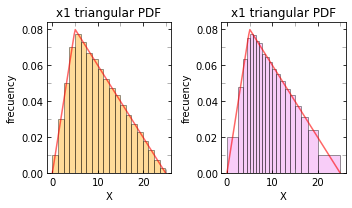

In [23]:
# Triangular PDF with mode =5 and mean = (a+b+mode)/3 = 10 
a_tri=0.
mode_tri = 5.
b_tri = 25.
x1a = np.array(triangularPDF(a_tri, mode_tri, b_tri, nMon=1000000))
triangularMomentsAndQantiles(a_tri, mode_tri, b_tri,0.68)
xMonSummaries_x1a = []
xMonSummaries_x1a = plot_PDF(x1a,0.68,0.68)
triangularPLOT(a_tri, mode_tri, b_tri,xsize=5,ysize= 3, title="x1 triangular PDF")

sigma_right = 0.7334293134224996
 Analitical values: mean   = 10.0000,   sigma = 4.4050;
                    median = 10.8407, Q0.16   = 5.5445, Q0.84 = 14.3676
     SUMMARIES    
 1) mean   = 10.0050, sigma     = 4.4023; (mean - sigma = 5.6027; mean - sigma = 14.4073; )
 2) median = 10.8502, Q0.16     = 5.5532, Q0.84     = 14.3678
 3) mode   = 14.7071, LowCL0.68 = 7.3847, upCL0.68 = 15.4592
     Test:    
mode-median-mean:  mode - median = 3.8570   median - mean = 0.8452
Dooson 1917:  mode - mean = 4.7021   3(median - mean) = 2.5355
    


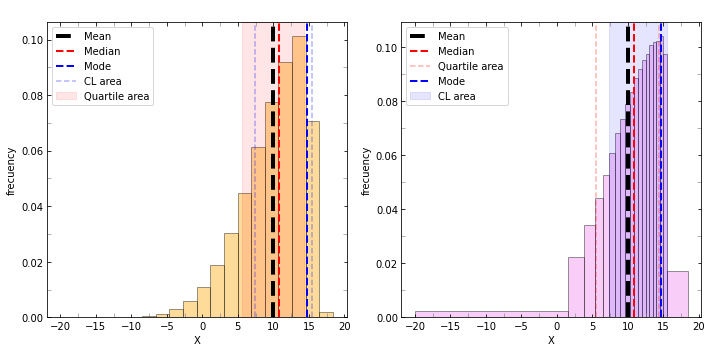

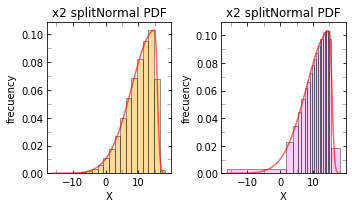

In [24]:
# Slitp normal PDF with mode =10 and mean = (mode + sqrt(2/pi) * (sig_r - sig_l)) = 15
mean_spn = 10.
mode_spn = 15.
sigl_spn = 7.
sigr_spn = (mean_spn - mode_spn)*np.sqrt(math.pi/2.) + sigl_spn
print("sigma_right =",sigr_spn)
x2a = np.array(splitnormalPDF(mode_spn,sigl_spn,sigr_spn,nMon=1000000))
splitnormalMomentsAndQantiles(mode_spn,sigl_spn,sigr_spn,0.68)
xMonSummaries_x2a = []
xMonSummaries_x2a = plot_PDF(x2a,0.68,0.68,xsize=10,ysize= 5)
splitnormalPLOT(mode_spn,sigl_spn,sigr_spn, xsize=5,ysize= 3, title="x2 splitNormal PDF")

### Notes about dispresion measurements and probabilities

Important enoguh:

- (median, quatiles) and (mode, minimun-intervals) provide information about the probabilities (since require to define integral limits)
- (mean, standard deviation) <b>DO NOT</b> povide information about probabilities (integral limits are always $-\infty, + \infty$)

The mean and variance have very special properties: 
<ul>
    <li><font color="green">the mean (and the variance) of a sum is the sum of the means (and the variance) whatever de distribution.</font> It sound trivial but it requires some advanced statistics as characteristic functions and cumulants (more later)</li>
    <li><font color="green"> the variance it is the <i>lowest posible measure dispersion</i></font> (being dispersion the distance with respect a given point): the distance of all the points respect to a point $c$ is (note that $\mu_2 = \mu'_2 - {\mu'}^2$)

\begin{eqnarray}
\mu_2(c) &=& \int (x -  c)^2\, f(x)\, \mathrm{d}x \nonumber \\
&= & \int (x^2 - 2\, c\,x + c^2)\, f(x)\, \mathrm{d}x  \nonumber \\
&= & \int (x^2 - {\mu'}^2 + {\mu'}^2 - 2\, c\,x + c^2)\, f(x)\, \mathrm{d}x  \nonumber \\
&= & \left(\int (x^2 f(x)\, \mathrm{d}x \right) - {\mu'}^2  + ( {\mu'}^2 - 2\, c\,\mu' + c^2 ) \\
&=&  \mu_2  {\color{red} + ( {\mu'} - c)^2 }
\end{eqnarray}

</li>
</ul>

## 3. Uncertainty propagation

Lets check how uncertainty propagation works and what is porpagated. To do show, let us assume a very very simple case, the linear combination of two variables 
<br><br>
<center>
    $ w = 3 \times x_1 + 2 \times x_2$ 
</center>
<br><br>
wich, atendign to uncertainty propagation formulae, the previos formule shoud work for the assumed central value and the final uncertainty $\delta_w$ should be obtained as:
<br><br>
<center>
    $  \delta_w^2 = 3 \times \delta_{x_1}^2 + 2 \times \delta_{x_2}^2 $ 
</center>
<br><br><br>

We also assume that  $x_1$ follows a triangularPDF and $x_2$ follows and split normal PDF with the following parameters:<br>
<table>
    <tr>
        <td></td>
        <td>$x_1$</td>
        <td></td>
        <td>$x_2$</td>
        <td></td>
    </tr>
    <tr>
        <td>Shape</td>
        <td>triangular</td>
        <td></td>
        <td>Slipt Normal</td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td>a=0, b=25, $\hat{x}=5$</td>
        <td>$\sigma$ or $\Delta/2$</td>
        <td>$\hat{x}=15$, $\sigma_l =7$, $\sigma_r=0.73$</td>
        <td>$\sigma$ or $\Delta/2$</td>
    </tr>
    <tr>
        <td>mean $\mu$</td>
        <td>10</td>
        <td>5.4</td>
        <td>10</td>
        <td>4.40</td>
    </tr>
    <tr>
        <td>median $\bar{x}^{+(\mathrm{84Q}-\bar{x})}_{-(\bar{x} - \mathrm{16Q})}$<br><br>
            <p style="font-size:8px">$\mathrm{16Q}, \bar{x}, \mathrm{84Q}$</p></td>
        <td>$9.19_{-4.72}^{+6.86}$<br><br>
            <p style="font-size:8px">$4.47, 9.19, 16.06$</p></td>
        <td>5.80</td>
        <td>$10.84_{-5.30}^{+3.53}$<br><br>
            <p style="font-size:8px">$5.54, 10.84, 14.37$</p></td>
        <td>4.42</td>
    </tr>
    <tr>
        <td>mode $\hat{x}^{+(\mathrm{upCL68}-\bar{x})}_{-(\bar{x} - \mathrm{lowCL68})}$<br><br>
            <p style="font-size:8px">$\mathrm{lowCL68}, \hat{x}, \mathrm{upCL68}$</p></td>
        <td>$5_{-2.54}^{+8.80}$<br><br>
            <p style="font-size:8px">$2.46, 5., 13.80$</p></td>
        <td>5.67</td>
        <td>$15_{-7.62}^{+0.46}$<br><br>
            <p style="font-size:8px">$7.38, 15., 15.46$</p></td>
        <td>4.04</td>
    </tr>
</table>

So we would expect (applying the $w$ formluae to reference values, 16Q, 84Q, lowCL68 y upCL68, and $\delta_w$ to $\sigma$ and $\Delta/2$): 

<table>
    <tr>
        <td></td>
        <td colspan = "4">$3 \times x_1 2 \times x_2$</td>
    </tr>
    <tr>
        <td>Shape</td>
        <td  colspan = "4">Unnkown (but see below)</td>
    </tr>
    <tr>
        <td></td>
        <td>reference value</td>
        <td>$\sigma$ or $\Delta/2$</td>
        <td>Intervals<br>
            (16Q,84Q, lowCL68, upCL68)</td>
        <td>Intervals<br>
            ref val(col2) $\pm \sigma$ or $\Delta/2$ (col3)</td>
    </tr>
    <tr>
        <td>mean $\mu$</td>
        <td>50</td>
        <td>11.23</td>
        <td></td>
        <td>(38.77, 61.23)</td>
    </tr>
    <tr>
        <td>median</td>
        <td>49.25</td>
        <td>11.67</td>
        <td>(24.49,76.92)</td>
        <td>(37.58,60.92)</td>
    </tr>
    <tr>
        <td>mode</td>
        <td>45</td>
        <td>11.36</td>
        <td>(22.14,72.32)</td>
        <td>(33.64,56.36)</td>
    </tr>
</table>

     SUMMARIES    
 1) mean   = 9.9961, sigma     = 5.4008; (mean - sigma = 4.5953; mean - sigma = 15.3969; )
 2) median = 9.1819, Q0.16     = 4.4696, Q0.84     = 16.0378
 3) mode   = 5.3123, LowCL0.68 = 2.4982, upCL0.68 = 13.8074
     Test:    
mode-median-mean:  mode - median = -3.8696   median - mean = -0.8142
Dooson 1917:  mode - mean = -4.6838   3(median - mean) = -2.4425
    


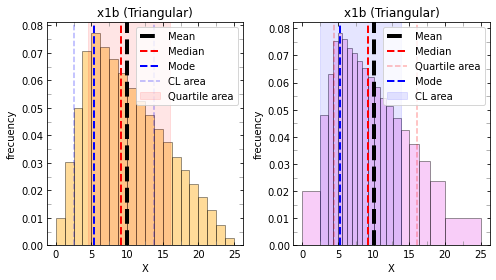

     SUMMARIES    
 1) mean   = 9.9884, sigma     = 5.4015; (mean - sigma = 4.5869; mean - sigma = 15.3899; )
 2) median = 9.1726, Q0.16     = 4.4601, Q0.84     = 16.0469
 3) mode   = 5.3072, LowCL0.68 = 2.4902, upCL0.68 = 13.8058
     Test:    
mode-median-mean:  mode - median = -3.8654   median - mean = -0.8158
Dooson 1917:  mode - mean = -4.6812   3(median - mean) = -2.4474
    


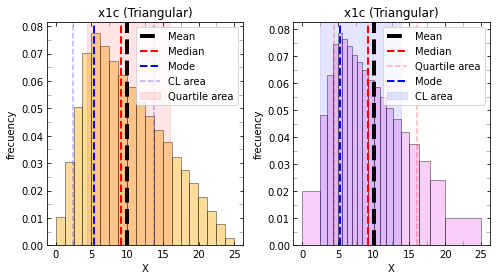

     SUMMARIES    
 1) mean   = 9.9998, sigma     = 4.4053; (mean - sigma = 5.5945; mean - sigma = 14.4051; )
 2) median = 10.8388, Q0.16     = 5.5484, Q0.84     = 14.3658
 3) mode   = 14.7069, LowCL0.68 = 7.3833, upCL0.68 = 15.4643
     Test:    
mode-median-mean:  mode - median = 3.8681   median - mean = 0.8390
Dooson 1917:  mode - mean = 4.7071   3(median - mean) = 2.5170
    


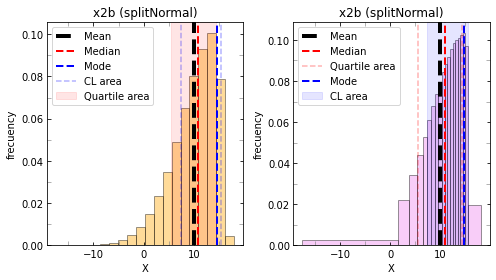

In [28]:
x1b = np.array(triangularPDF(a_tri, mode_tri, b_tri,nMon=1000000))
xMonSummaries_x1b = []
xMonSummaries_x1b = plot_PDF(x1b,0.68,0.68,xsize=7,ysize=4,title="x1b (Triangular)")
x1c = np.array(triangularPDF(a_tri, mode_tri, b_tri,nMon=1000000))
xMonSummaries_x1c = []
xMonSummaries_x1c = plot_PDF(x1c,0.68,0.68,xsize=7,ysize=4,title="x1c (Triangular)")
x2b = np.array(splitnormalPDF(mode_spn,sigl_spn,sigr_spn,nMon=1000000))
xMonSummaries_x2b = []
xMonSummaries_x2b = plot_PDF(x2b,0.68,0.68,xsize=7,ysize=4,title="x2b (splitNormal)")

     SUMMARIES    
 1) mean   = 49.9939, sigma     = 11.2389; (mean - sigma = 38.7550; mean - sigma = 61.2328; )
 2) median = 49.8489, Q0.16     = 38.8106, Q0.84     = 61.2613
 3) mode   = 49.1385, LowCL0.68 = 38.3616, upCL0.68 = 61.7509
     Test:    
mode-median-mean:  mode - median = -0.7104   median - mean = -0.1450
Dooson 1917:  mode - mean = -0.8554   3(median - mean) = -0.4351
    


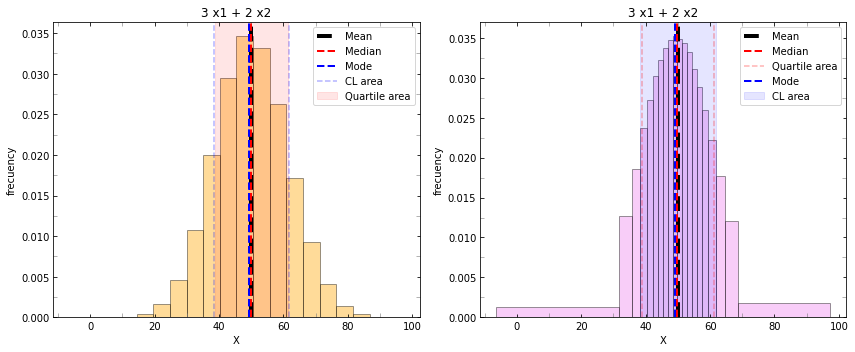

In [29]:
w = np.array(empty(1000000))
w = np.add(x1a,x1b)
w = np.add(w,x1c)
w = np.add(w,x2a)
w = np.add(w,x2b)
xMonSummaries_x2b = []
xMonSummaries_x2b = plot_PDF(w, 0.68, 0.68,title="3 x1 + 2 x2")

In [30]:
a = []
a = powerlawMomentsAndQantiles(1,15,-2.35,0.68)

 Analitical values: mean   = 2.4248,   sigma = 2.0936;
                    median = 1.6398, Q0.16   = 1.1337, Q0.84 = 3.5369


     SUMMARIES    
 1) mean   = 24.2476, sigma     = 6.6244; (mean - sigma = 17.6231; mean - sigma = 30.8720; )
 2) median = 23.1216, Q0.16     = 17.8203, Q0.84     = 30.7739
 3) mode   = 19.6270, LowCL0.68 = 15.5644, upCL0.68 = 28.1309
     Test:    
mode-median-mean:  mode - median = -3.4946   median - mean = -1.1260
Dooson 1917:  mode - mean = -4.6206   3(median - mean) = -3.3780
    


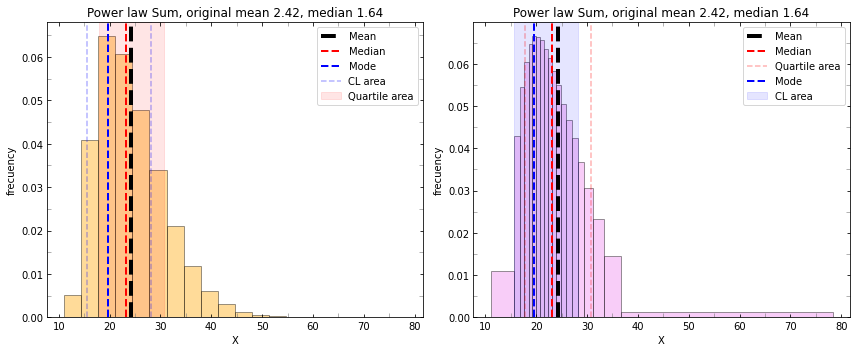

In [31]:
x3_1 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_2 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_3 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_4 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_5 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_6 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_7 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_8 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_9 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))
x3_10 = np.array(powerlawPDF(1,15,-2.35,nMon=1000000))

w2 = np.array(empty(1000000))
w2 = np.add(x3_1,x3_2)
w2 = np.add(w2,x3_3)
w2 = np.add(w2,x3_4)
w2 = np.add(w2,x3_5)
w2 = np.add(w2,x3_6)
w2 = np.add(w2,x3_7)
w2 = np.add(w2,x3_8)
w2 = np.add(w2,x3_9)
w2 = np.add(w2,x3_10)
xMonSummaries_w2 = []
xMonSummaries_w2 = plot_PDF(w2, 0.68, 0.68,title="Power law Sum, original mean 2.42, median 1.64")

### Summary

<table>
    <tr>
        <td></td>
        <td colspan = "5"><center>$w =3 \times x_1  + 2 \times x_2$</center></td>
    </tr>
    <tr>
        <td>Shape</td>
        <td  colspan = "5">Gaussian-like (quite symetric!!)</td>
    </tr>
    <tr>
        <td></td>
        <td>reference value</td>
        <td>$\sigma$ or $\Delta/2$</td>
        <td>Intervals<br>
            (16Q,84Q, lowCL68, upCL68)</td>
        <td>Intervals<br>
            ref val(col2) $\pm \sigma$ or $\Delta/2$ (col3)</td>
        <td><b>Result</b></td>
    </tr>
    <tr>
        <td>&#128073; mean $\mu$ &#129392;</td>
        <td><font color="green">50</font></td>
        <td><font color="green">11.23</font></td>
        <td></td>
        <td><font color="green">(38.77, 61.23)</font></td>
        <td><b>50.01 (38.77,61.25) $\sigma = 11.24$</b></td>
    </tr>
    <tr>
        <td>median &#129488;&#128530;</td>
        <td><font color="red">49.25</font></td>
        <td><font color="red">11.67</font></td>
        <td><font color="red">(24.49,76.92)</font></td>
        <td><font color="red">(37.58,60.92)</font></td>
        <td><b>49.88 (38.82, 61.29) $\Delta/2= 11.235$</b></td>
    </tr>
    <tr>
        <td>mode &#129318;&#127996; &#128534;</td>
        <td><font color="red">45</font></td>
        <td><font color="red">11.36</font></td>
        <td><font color="red">(22.14, 72.32)</font></td>
        <td><font color="red">(33.64, 56.36)</font></td>
        <td><b>49.17 (38.36, 61.77) $\Delta/2= 11.705$</b></td>
    </tr>
</table>

Actually, all of this is quoted in the <a href="https://www.iso.org/sites/JCGM/GUM-introduction.htm"><i>Guide to the expresion of uncertainty in measurements, GUM</i></a> (and in more stataisitical books), and all avanced probability theories works with means $\mu$ and variuances $\sigma^2$, there is a formal mathematical framework to do so!!, but... 


<blockquote>"... There is, instead, no probability theory theorem
which gives a simple propagation rule of mode, median and probability intervals... " </blockquote>
<div align="right">D'Agostini (2013)</div>

#### Another more clear example (power laws)

In [32]:
xdum = [] 
xdum = powerlawMomentsAndQantiles(1.,20.,-2.35,0.68)

 Analitical values: mean   = 2.5500,   sigma = 2.4901;
                    median = 1.6497, Q0.16   = 1.1351, Q0.84 = 3.6411


Print Original Values (again):
 Analitical values: mean   = 2.5500,   sigma = 2.4901;
                    median = 1.6497, Q0.16   = 1.1351, Q0.84 = 3.6411
  
   Exepected values: mean= 25.5005, std= 7.8743
  
     SUMMARIES    
 1) mean   = 25.5108, sigma     = 7.9080; (mean - sigma = 17.6028; mean - sigma = 33.4188; )
 2) median = 23.8679, Q0.16     = 18.0525, Q0.84     = 33.2494
 3) mode   = 19.9912, LowCL0.68 = 15.6881, upCL0.68 = 29.9314
     Test:    
mode-median-mean:  mode - median = -3.8767   median - mean = -1.6428
Dooson 1917:  mode - mean = -5.5195   3(median - mean) = -4.9285
    


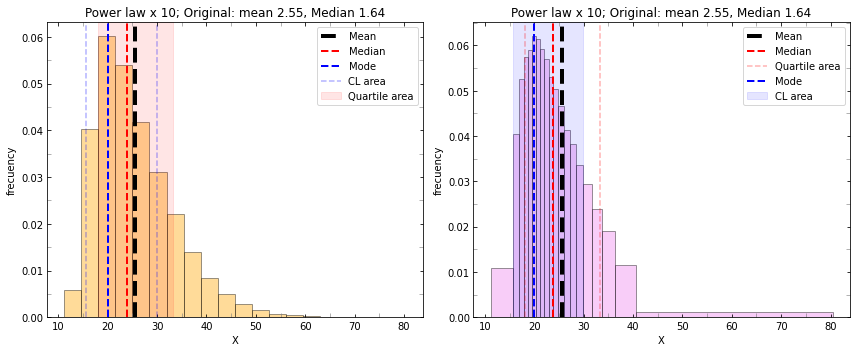

In [33]:
x3_1 = np.array(powerlawPDF(1.,20.,-2.35))
x3_2 = np.array(powerlawPDF(1.,20.,-2.35))
x3_3 = np.array(powerlawPDF(1.,20.,-2.35))
x3_4 = np.array(powerlawPDF(1.,20.,-2.35))
x3_5 = np.array(powerlawPDF(1.,20.,-2.35))
x3_6 = np.array(powerlawPDF(1.,20.,-2.35))
x3_7 = np.array(powerlawPDF(1.,20.,-2.35))
x3_8 = np.array(powerlawPDF(1.,20.,-2.35))
x3_9 = np.array(powerlawPDF(1.,20.,-2.35))
x3_10 = np.array(powerlawPDF(1.,20.,-2.35))
w2 = np.array(empty(1000000))
w2 = np.add(x3_1,x3_2)
w2 = np.add(w2,x3_3)
w2 = np.add(w2,x3_4)
w2 = np.add(w2,x3_5)
w2 = np.add(w2,x3_6)
w2 = np.add(w2,x3_7)
w2 = np.add(w2,x3_8)
w2 = np.add(w2,x3_9)
w2 = np.add(w2,x3_10)

print(f'Print Original Values (again):')
xdum = powerlawMomentsAndQantiles(1.,20.,-2.35,0.68)
print('  ')
print(f"   Exepected values: mean= {(xdum[0]*10.):.4f}, std= {(xdum[1]*np.sqrt(10.)):.4f}")
print('  ')
xMonSummaries_x3b = []
xMonSummaries_x3b = plot_PDF(w2, 0.68, 0.68,title="Power law x 10; Original: mean 2.55, Median 1.64")

## Take home points

&#128073; You can use whatever you want to describe a PDF and uncertainties (If you are a gambler, mode and confidence interval is, some how, more realistic as summary)

&#128073; For histograms (and related integrals in probability!!) The meaning of limits must be <font color="green">$a \le x \lt b$</font> or <font color="green">$a \lt x \le b$</font> but never <font color="red">$a \le x \le b$</font>

<br>
If you want to provide values to be used later by others (or if you want to propagate uncertinties)
<center>
     &#128073; <font color="green">provide ALWAYS <b>mean, $\mu$</b> and <b>standard deviation, $\sigma$</b> or <b>variance, $\sigma^2$</b></font><br>
since <font color="green"><b>they are the only ones that works in uncertainty propagation formlae</b></font>!!
</center>
<br>
and do not get confussed by the fact that median and mean values are close ech other!!

&#128073; Standard devidation <font color="green">DO NOT PROVIDE confidence interval</font> ($\mu \pm \sigma$ makes no sense unless the PDF is gaussian, and it is not always the case!!)

&#128073; Equaly, a probability inteval of 68% can be obtained in very difrent ways (about mean, median or mode). But acutally, the use of the magic number of 68% have to do gaussian you can use the value you want.

## Bonus track: Gaia, paralax, $\left< 1/x \right>$ and $\sigma^2(1/x)$

From Cerviño &amp; Valls-Gabaud M.N.R.A.S. 2003, 338, 481 <a href="https://ui.adsabs.harvard.edu/abs/2003MNRAS.338..481C/abstract">On biases in the predictions of stellar population synthesis models</a>, where it is studied the case of ratio distributions. Lets  $x_\pi$ be the paralax, $\mu_\pi$ the mean value obtained from GAIA observations, and $\sigma_\pi$ the standard deviation of $\mu_\pi$ (which would vary when the number of observations incerases). The distance is then obtained as $d = 1/x_\pi$. Making a Taylor expansion around $\mu_\pi$ 
<center>
    \begin{equation}
          \frac{1}{x_\pi} = \sum_{n \ge 0} (-1)^n \frac{1}{\mu_\pi} \frac{(x_\pi - \mu_\pi)^n}{\mu_\pi^n} = \frac{1}{\mu_\pi}\left(1 - \frac{x_\pi-\mu_\pi}{\mu_\pi}  + \frac{(x_\pi-\mu_\pi)^2}{\mu_\pi^2} - \frac{(x_\pi-\mu_\pi)^3}{\mu_\pi^3} + \dots \right)
     \end{equation}
</center>

then, we can obtain the mean and variance using the "expectation value" operator $\mathrm{E}[f(x)] = \int f(x)\, \varphi(x) \mathrm{d}x$ and $\mathrm{var}[f(x)] = \mathrm{E}[f(x)^2] - \mathrm{E}[f(x)]^2$:

<center>
    \begin{eqnarray}
        \mu\left(\frac{1}{\pi}\right) & = & \frac{1}{\mu_\pi} \left( 1 + \frac{\sigma_\pi^2}{\mu_\pi^2} \color{grey}{-  \frac{\mu_{3}(\pi)}{\mu_\pi^3}  + \dots} \right) \\
        \sigma^2 \left(\frac{1}{\pi}\right) & = & \frac{\sigma^2_\pi}{\mu_\pi^4} \left( 1 - \frac{\sigma_\pi^2}{\mu_\pi^2}\color{grey}{ - \frac{2 \mu_{3,\pi}}{\mu_\pi \sigma^2_\pi} \left(1- \frac{\sigma^2_\pi}{\mu_\pi^2} + \frac{\mu_{3,\pi}}{2\,\mu_\pi^3} +  \dots  \right)} \right)           \\
        \end{eqnarray}
</center>

Moments Original PDF x
 Analitical values: mean   = 2.0000,   sigma = 0.4082;
                    median = 2.0000, Q0.16   = 1.5657, Q0.84 = 2.4343

Moments PDF (1/x)
mean (1st order): 0.5 sigma (1st order): 0.10206207261596575
mean (2nd order): 0.5208333333333334 sigma (2nd order): 0.09991315673568166

     SUMMARIES    
 1) mean   = 0.5232, sigma     = 0.1178; (mean - sigma = 0.4054; mean - sigma = 0.6410; )
 2) median = 0.4999, Q0.16     = 0.4109, Q0.84     = 0.6388
 3) mode   = 0.4811, LowCL0.68 = 0.3726, upCL0.68 = 0.5857
     Test:    
mode-median-mean:  mode - median = -0.0188   median - mean = -0.0233
Dooson 1917:  mode - mean = -0.0420   3(median - mean) = -0.0698
    


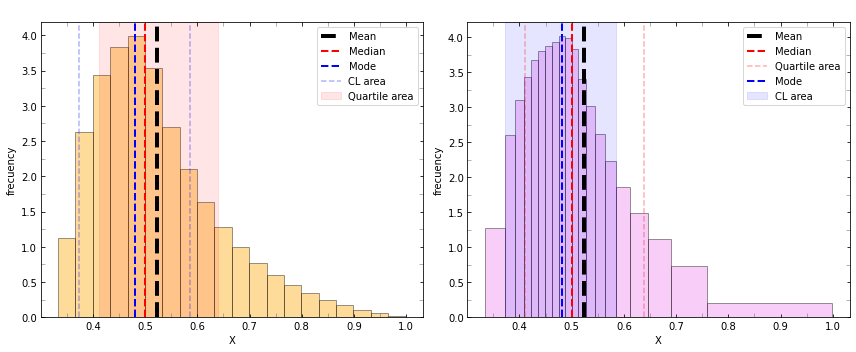

(0.5231767762915853,
 0.11780364208323664,
 0.49990346853847833,
 0.410895170814258,
 0.6387567904966084,
 0.48113822224439806,
 0.3726366609311894,
 0.5856768793685929)

In [34]:
nMon = 1000000
d = np.array(empty(nMon))
xPI = np.array(triangularPDF(1., 2.,3.,nMon=nMon))
#xPI = np.array(splitnormalPDF(2., 0.5,0.3,nMon=nMon))
print("Moments Original PDF x")
xmeanPi,xstdPi,xmodePi,xQ1Pi,xQ2Pi = triangularMomentsAndQantiles(1., 2.,3.,0.68)
#xmeanPi,xstdPi,xmodePi,xQ1Pi,xQ2Pi = splitnormalMomentsAndQantiles(2., 0.5,0.3,0.68)
print("")
print("Moments PDF (1/x)")
print("mean (1st order):",1./xmeanPi,"sigma (1st order):",xstdPi/(xmeanPi*xmeanPi))
print("mean (2nd order):",(1./xmeanPi)*(1.+(xstdPi*xstdPi/(xmeanPi*xmeanPi))),
      "sigma (2nd order):",(xstdPi/(xmeanPi*xmeanPi))*np.sqrt(1.-(xstdPi*xstdPi/(xmeanPi*xmeanPi))))
print("")
d=1/xPI
plot_PDF(d, 0.68, 0.68,ylog=False)

This is the reason that GAIA distances would vary with the relase: the distance estimate depends on the uncertainty in the estimate of the paralax.. It is supposed that such uncertainty in the estimate will converge towards an estable value (and hence, the estimate of the distance)

Also note that the variance in the distance is not so easily reproduced analyticaly ... 

## Further read:

<font size="-1">
<ul>
    <ol>
        <li>Representation
            <ul>
                <li>Kendall's Advanced Theory of Statistics (Vol 1 Cap.1)</li>
                <li>Maíz-Apellániz &amp Úbeda Ap.J. 2005, 629, 873, <a href="https://ui.adsabs.harvard.edu/abs/2005ApJ...629..873M/abstract"><i>Numerical Biases on Initial Mass Function Determinations Created by Binning</i></a></li>
                <li>Cerviño et al. 2013, A&amp;A 553, A31,  <a href="https://ui.adsabs.harvard.edu/abs/2013A%26A...553A..31C/abstract"><i>Crucial aspects of the initial mass function. I. The statistical correlation between the total mass of an ensemble of stars and its most massive star</i></a></li>
            </ul>
        </li>
        <li>Measurement of location and dispersion
            <ul>
                <li>Kendall's Advanced Theory of Statistics (Vol 1 Cap.2)</li>
                <li><font color="green" >&#128073; </font>D'Agostini & Raso (2000) <a href="http://arxiv.org/abs/hep-ex/0002056v1">Uncertainties due to imperfect knowledge of systematic effects</a> Asimetric uncertinties</li>
            </ul>
        </li>
        <li>Uncertainty propagation
            <ul>
                <li><a href="https://www.iso.org/sites/JCGM/GUM-introduction.htm"><i>Guide to the expresion of uncertainty in measurements, GUM</i></a> (form the International Standarization Organization, ISO)<br>
            In particular <a href="https://www.iso.org/sites/JCGM/GUM/JCGM100/C045315e-html/C045315e.html?csnumber=50461">Sect 7: Reporting uncertainty</a></li>
                <li>D'Agostini (2013) <i>Bayesian reasoning in data analisys . A critical introduction</i> World Scientific Publishing 2003 (<a href="https://www.roma1.infn.it/~dagos/WSPC/index.html">Table of contents</a>)</li>
                <li>Cerviño &amp; Valls-Gabaud M.N.R.A.S. 2003, 338, 481 <a href="https://ui.adsabs.harvard.edu/abs/2003MNRAS.338..481C/abstract">On biases in the predictions of stellar population synthesis models</a></li>
            </ul>
        </li>
        <li>Moments, cumulants and PDF description from them (IMF, integrated luminosity, the dependence with numer of stars, and so on)
            <ul>
              <li>Kendall's Advanced Theory of Statistics (Vol 1 Cap.4)</li>
                <li>Cerviño &map; Luiridiana 2006, A&amp;A 451, 475 <a href="https://ui.adsabs.harvard.edu/abs/2006A%26A...451..475C/abstract">Confidence limits of evolutionary synthesis models. IV. Moving forward to a probabilistic formulation</a></li>
            </ul>
        </li>
    </ol>
</ul>
</font>